In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes


In [66]:
#params
weather_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\raw\weather_train.csv"
train_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\raw\train.csv"
building_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\raw\building_metadata.csv"
output_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\processed\merged_data.csv"

# Set seaborn style
sns.set(style="whitegrid")
colors = sns.color_palette("muted")

class_labels = {0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}


# Load

In [4]:
#RAM 
def randomize_and_filter_dataset(file_path, target_size, random_seed=42):
    df = pd.read_csv(file_path)
    print('Before:',df.shape)
    np.random.seed(random_seed)
    indices_to_keep = np.random.choice(df.index, size=target_size, replace=False)
    filtered_data = df.loc[indices_to_keep]
    return filtered_data
# Example usage:
train = randomize_and_filter_dataset(train_file, target_size=30)
print('After:',train.shape)

Before: (20216100, 4)
After: (30, 4)


In [5]:
#Read and merge train csv
#weather_train.csv: site_id
#train.csv : building_id
#building_metadata.csv: site_id building_id

def break_datetime(df):
  df['timestamp_x']= pd.to_datetime(df['timestamp_x'])
  df['hour']= np.uint8(df['timestamp_x'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp_x'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp_x'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp_x'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp_x'].dt.day)
  df['year']= np.uint16(df['timestamp_x'].dt.year)
  return df

def merge_csv_files(weather_file, train, building_file, output_file):
    # Read the CSV files
    weather_train = pd.read_csv(weather_file)
    #train = pd.read_csv(train_file)
    building_metadata = pd.read_csv(building_file)
    # Merge the dataframes
    merged_data =pd.merge(pd.merge(building_metadata, train, on='building_id'), weather_train, on='site_id')
    #Timestamp processing
    merged_data= break_datetime(merged_data)
    # Save the merged dataframe to a new CSV file
    merged_data.to_csv(output_file)
    return merged_data

train_df = merge_csv_files(weather_file, train, building_file, output_file)
print("Merged data saved to merged_data.csv", train_df.shape)

Merged data saved to merged_data.csv (262305, 17)


In [4]:
#Load
train_df=pd.read_csv(r'C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\processed\merged_data.csv')

# EDA

In [98]:
train_df['meter_reading'].describe()

count    262305.000000
mean        181.936208
std         299.968978
min           0.000000
25%           9.250000
50%          29.180000
75%         247.000000
max        1106.100000
Name: meter_reading, dtype: float64

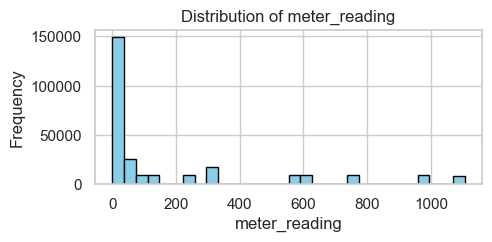

In [61]:
def plot_histogram(data, column_name, num_bins=30, color='skyblue', edgecolor='black', figsize=(5, 2)):
    """
    Generate a histogram for the specified column in the DataFrame.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column for which the histogram is to be generated.
        num_bins (int): Number of bins in the histogram.
        color (str): Color of the histogram bars.
        edgecolor (str): Color of the edges of the bars.
        figsize (tuple): Size of the figure (width, height).
    """
    plt.figure(figsize=figsize)
    plt.hist(data[column_name], bins=num_bins, color=color, edgecolor=edgecolor)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(train_df, 'meter_reading')

In [104]:
# Perform log transformation
train_df['log_' + 'meter_reading'] = np.log1p(train_df['meter_reading'])  

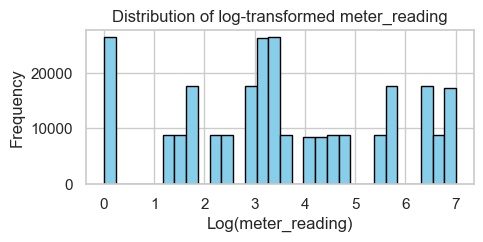

In [63]:
def plot_log_transformed_histogram(data, column_name, num_bins=30, color='skyblue', edgecolor='black', figsize=(5, 2)):
    """
    Generate a histogram for the log-transformed specified column in the DataFrame.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to be log-transformed and plotted.
        num_bins (int): Number of bins in the histogram.
        color (str): Color of the histogram bars.
        edgecolor (str): Color of the edges of the bars.
        figsize (tuple): Size of the figure (width, height).
    """
    log_transformed_column = 'log_' + column_name
    data[log_transformed_column] = np.log1p(data[column_name])  # Log-transform the specified column
    
    plt.figure(figsize=figsize)
    plt.hist(data[log_transformed_column], bins=num_bins, color=color, edgecolor=edgecolor)
    plt.title(f'Distribution of log-transformed {column_name}')
    plt.xlabel('Log(' + column_name + ')')
    plt.ylabel('Frequency')
    plt.show()

plot_log_transformed_histogram(train_df, 'meter_reading')

In [64]:
train_df['log_meter_reading'].describe()

count    262305.000000
mean          3.603006
std           2.026340
min           0.000000
25%           2.327278
50%           3.407179
75%           5.513429
max           7.009499
Name: log_meter_reading, dtype: float64

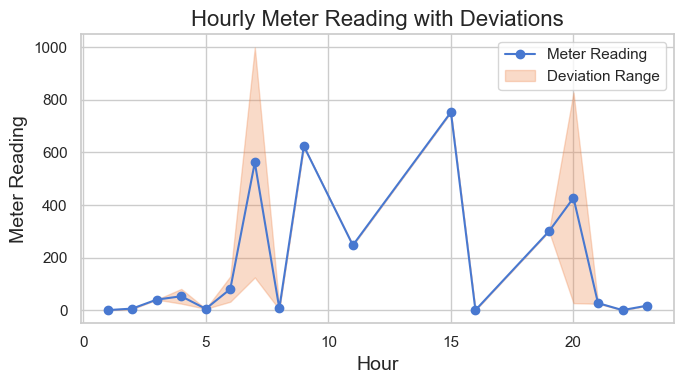

In [69]:

def plot_hourly_meter_reading_with_deviations(train_df):
    """
    Plot hourly meter readings with shaded region representing standard deviations.
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a datetime index and 'meter_reading' column.
        figsize (tuple): Size of the figure (width, height).
        colors (list): List of color values for the plot (default is None, which uses default colors).
    """
    
    # Calculate mean and standard deviation for each hour
    hourly_stats = train_df['meter_reading'].groupby(train_df.hour).agg(['mean', 'std'])
    # Extract hours, mean values, and standard deviations
    hours = hourly_stats.index
    mean_values = hourly_stats['mean']
    std_devs = hourly_stats['std']

    # Plotting the data with a shaded region representing standard deviations
    plt.figure(figsize=(7, 4))
    plt.plot(hours, mean_values, marker='o', color=colors[0], label='Meter Reading')
    plt.fill_between(hours, mean_values - std_devs, mean_values + std_devs, color=colors[1], alpha=0.3, label='Deviation Range')
    plt.title('Hourly Meter Reading with Deviations', fontsize=16)
    plt.xlabel('Hour', fontsize=14)
    plt.ylabel('Meter Reading', fontsize=14)
    plt.xticks(np.arange(0, 24, 5))  # Show ticks for each hour
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hourly_meter_reading_with_deviations(train_df)

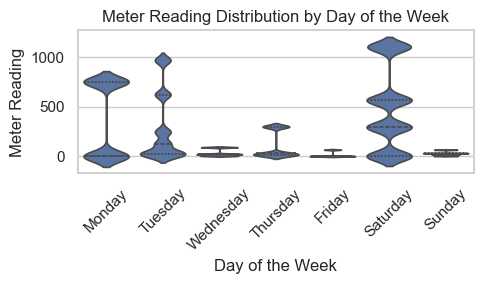

In [13]:
def plot_meter_reading_by_day(train_df):
    """
    Plot meter reading distribution by day of the week using a violin plot.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a datetime index and 'meter_reading' column.
    """
    # Extract day of the week from the datetime index
    train_df['day_of_week'] = train_df.dayofweek
    # Set the order of days for proper plotting
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Create a violin plot for each day of the week
    plt.figure(figsize=(5, 3))
    sns.violinplot(data=train_df, x="day_of_week", y="meter_reading",density_norm="width",inner="quartile")
    plt.title('Meter Reading Distribution by Day of the Week', fontsize=12)
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Meter Reading', fontsize=12)
    plt.xticks(ticks=range(len(day_order)), labels=day_order, rotation=45)
    plt.tight_layout()
    plt.show()
    
plot_meter_reading_by_day(train_df)


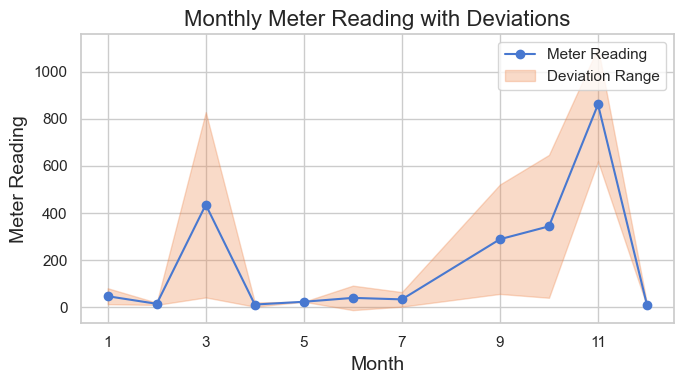

In [70]:
def plot_hourly_meter_reading_with_deviations(train_df):
    """
    Plot hourly meter readings with shaded region representing standard deviations.
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a datetime index and 'meter_reading' column.
        figsize (tuple): Size of the figure (width, height).
        colors (list): List of color values for the plot (default is None, which uses default colors).
    """
    
    # Calculate mean and standard deviation for each hour
    m_stats = train_df['meter_reading'].groupby(train_df.month).agg(['mean', 'std'])
    # Extract hours, mean values, and standard deviations
    months = m_stats.index
    mean_values = m_stats['mean']
    std_devs = m_stats['std']

    # Plotting the data with a shaded region representing standard deviations
    plt.figure(figsize=(7, 4))
    plt.plot(months, mean_values, marker='o', color=colors[0], label='Meter Reading')
    plt.fill_between(months, mean_values - std_devs, mean_values + std_devs, color=colors[1], alpha=0.3, label='Deviation Range')
    plt.title('Monthly Meter Reading with Deviations', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Meter Reading', fontsize=14)
    plt.xticks(np.arange(1, 13, 2))  # Show ticks for each hour
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hourly_meter_reading_with_deviations(train_df)

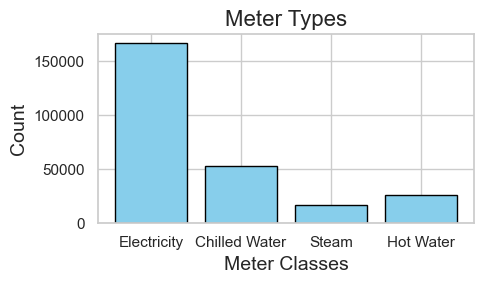

In [15]:

def plot_meter_classes(train_df, class_labels):
    """
    Plot a histogram of meter classes with specified class labels.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a 'meter' column.
        class_labels (dict): Dictionary mapping meter classes to corresponding names.
    """
    # Map the class labels to the 'meter' column and create a new column 'meter_class'
    train_df['meter_class'] = train_df['meter'].map(class_labels)

    # Create a histogram of meter classes
    plt.figure(figsize=(5, 3))
    plt.hist(train_df['meter'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5], align='mid', rwidth=0.8, color='skyblue', edgecolor='black')
    plt.title('Meter Types', fontsize=16)
    plt.xlabel('Meter Classes', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    # Set x-ticks in the middle of each class and label them
    plt.xticks(range(4), [class_labels[i] for i in range(4)])

    plt.tight_layout()
    plt.show()


plot_meter_classes(train_df, class_labels)

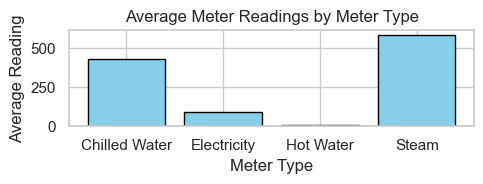

In [17]:

def average_meter_readings(train_df):
    # Calculate average meter readings by meter type
    average_meter_readings = train_df.groupby('meter_class')['meter_reading'].mean()

    # Create a histogram of average meter readings by meter type
    plt.figure(figsize=(5, 2))
    plt.bar(average_meter_readings.index, average_meter_readings.values, color='skyblue', edgecolor='black')
    plt.title('Average Meter Readings by Meter Type', fontsize=12)
    plt.xlabel('Meter Type', fontsize=12)
    plt.ylabel('Average Reading', fontsize=12)

    plt.tight_layout()
    plt.show()
    
average_meter_readings(train_df)

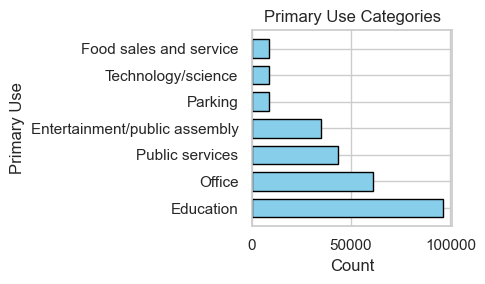

In [54]:

def plot_primary_use_categories_horizontal(train_df):
    """
    Plot a visually appealing horizontal bar histogram of primary use categories with spaces between bins.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a 'primary_use' column.
    """
    # Count the occurrences of each primary use category
    primary_use_counts = train_df['primary_use'].value_counts()

    # Create a horizontal bar histogram of primary use categories with spaces between bins
    plt.figure(figsize=(5, 3))
    plt.barh(primary_use_counts.index, primary_use_counts.values, height=0.7, color='skyblue', edgecolor='black')
    plt.title('Primary Use Categories', fontsize=12)
    plt.ylabel('Primary Use', fontsize=12)
    plt.xlabel('Count', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_primary_use_categories_horizontal(train_df)


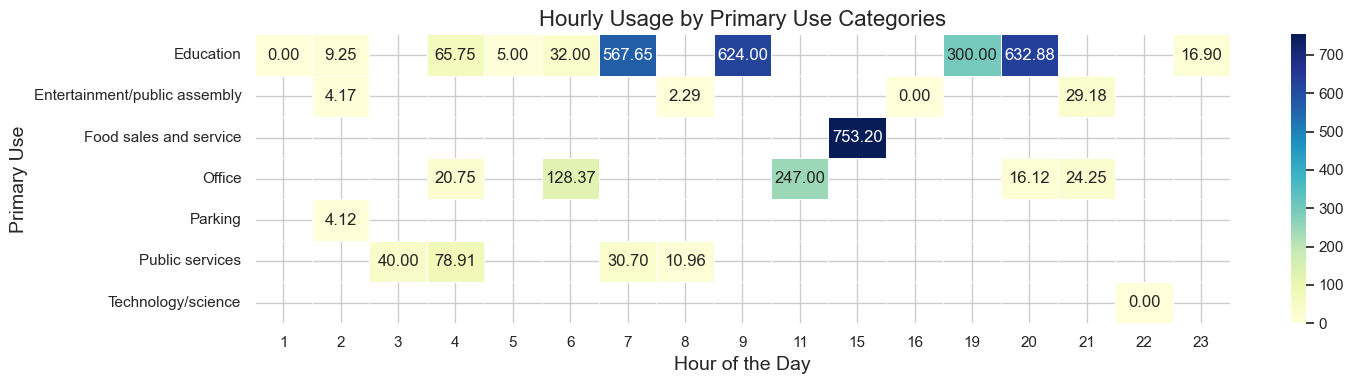

In [91]:
def hourly_usage_primary_use(train_df):
    # Pivot the data to get the hourly usage for each primary use category
    hourly_usage_by_primary_use = train_df.pivot_table(index='primary_use', columns=train_df.hour, values='meter_reading', aggfunc='mean')

    # Create a heatmap
    plt.figure(figsize=(15, 4))
    sns.heatmap(hourly_usage_by_primary_use, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)
    plt.title('Hourly Usage by Primary Use Categories', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Primary Use', fontsize=14)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
hourly_usage_primary_use(train_df)

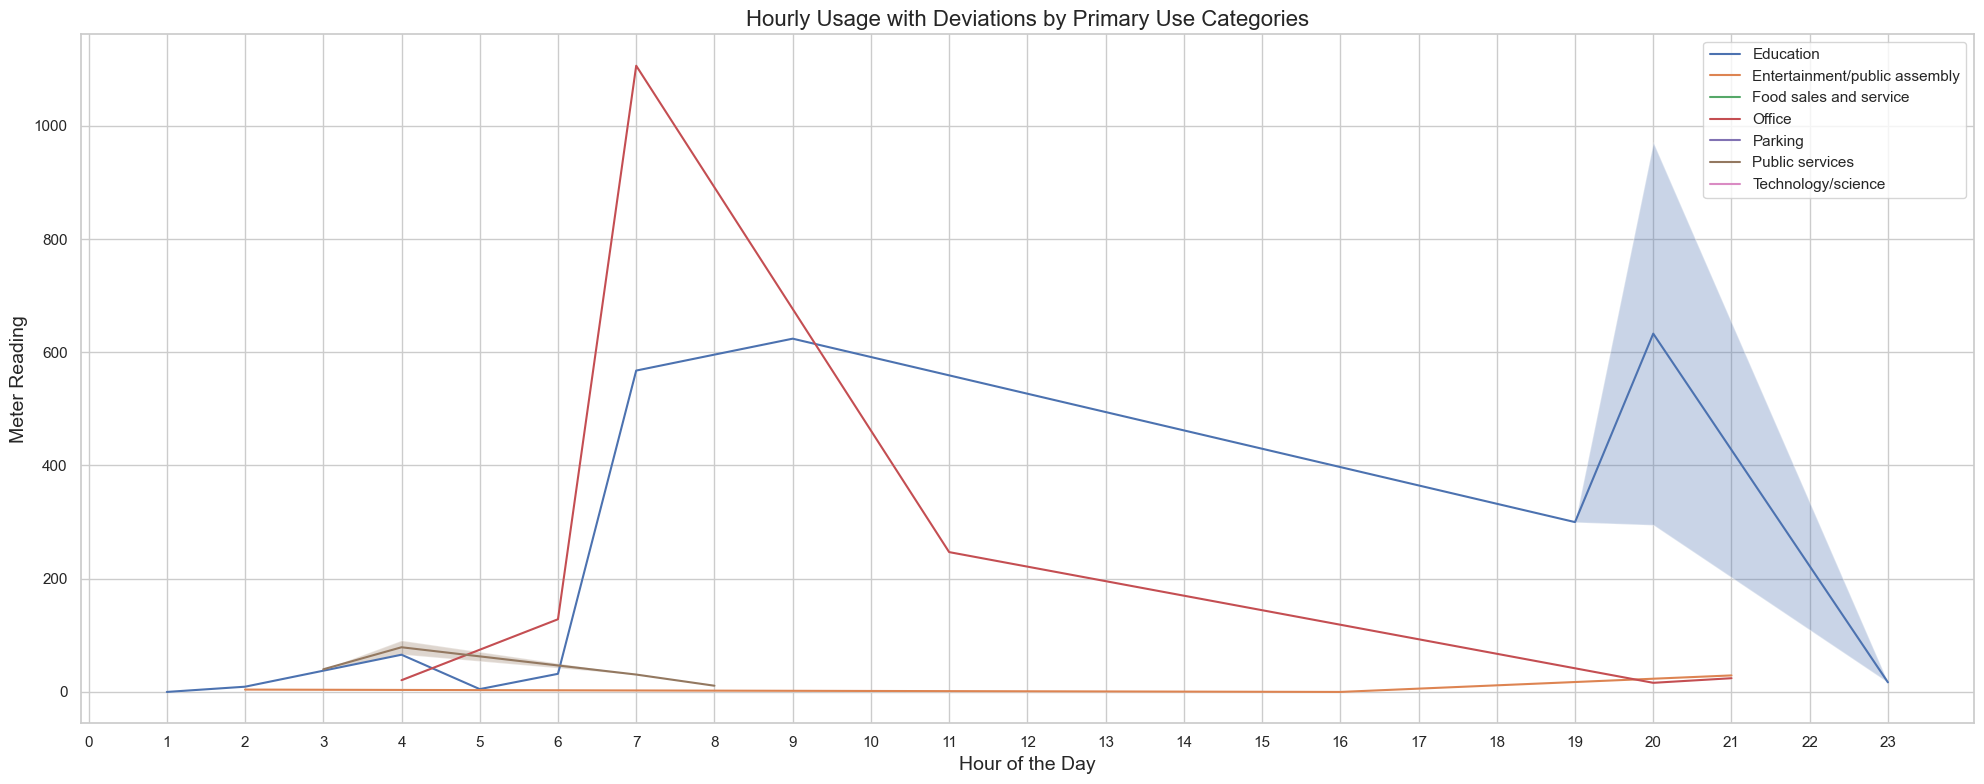

In [85]:
def plot_hourly_usage_with_deviations(train_df):
    """
    Plot line graphs with deviations for hourly usage for each primary use category.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'primary_use', 'meter_reading', and 'timestamp' columns.
    """
    # Calculate mean and standard deviation for each hour within each primary use category
    hourly_stats_by_primary_use = train_df.groupby(['primary_use', train_df.hour])['meter_reading'].agg(['mean', 'std'])

    # Plot line graphs with shaded regions representing deviations for each primary use category
    plt.figure(figsize=(20, 8))
    for primary_use_category, hourly_stats in hourly_stats_by_primary_use.groupby(level=0):
        plt.plot(hourly_stats.index.get_level_values(1), hourly_stats['mean'], label=primary_use_category)
        plt.fill_between(hourly_stats.index.get_level_values(1), hourly_stats['mean'] - hourly_stats['std'], 
                         hourly_stats['mean'] + hourly_stats['std'], alpha=0.3)

    plt.title('Hourly Usage with Deviations by Primary Use Categories', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Meter Reading', fontsize=14)
    plt.legend()
    plt.xticks(range(24))
    plt.tight_layout()
    plt.show()

plot_hourly_usage_with_deviations(train_df)

- The peak usage for educational institutes has the peak usage from morning 9 am until 3 pm and then the usage drops. This is explained as most educational institutes are operational during day time only.
- The consumption for entertainment as well as food sales buildings rises after 10 and continues to remain stable until 8 pm.
- The healthcare and residential buildings have a similar pattern of usage as it peaks around 4 pm and then drops in the evening.
- The office buildings, retail, technology and public services buildings also consume most of the energy in the daytime mainly from 10 am to 4 pm.
- The parking has the minimum usage in the morning hours and the consumption rises after 3 pm.
- The religious buildings consume the least energy and utilities consume the most.

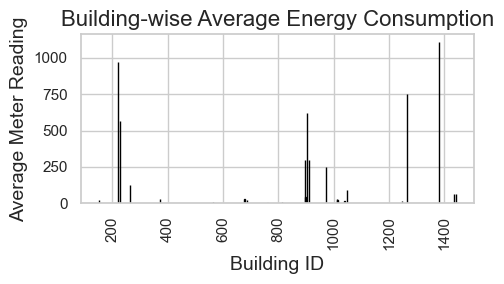

In [87]:
def plot_building_wise_energy_consumption(train_df):
    """
    Plot bar chart for building-wise average energy consumption.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'building_id' and 'meter_reading' columns.
    """
    # Calculate mean energy consumption for each building
    building_avg_energy = train_df.groupby('building_id')['meter_reading'].mean()

    # Sort buildings by average energy consumption in descending order
    building_avg_energy = building_avg_energy.sort_values(ascending=False)

    # Plot bar chart for building-wise average energy consumption
    plt.figure(figsize=(5, 3))
    plt.bar(building_avg_energy.index, building_avg_energy.values, color='skyblue', edgecolor='black')
    plt.title('Building-wise Average Energy Consumption', fontsize=16)
    plt.xlabel('Building ID', fontsize=14)
    plt.ylabel('Average Meter Reading', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_building_wise_energy_consumption(train_df)

The above plot shows that there is a huge spike of usage in one of the buildings. This clearly indicates the presence of an outlier.

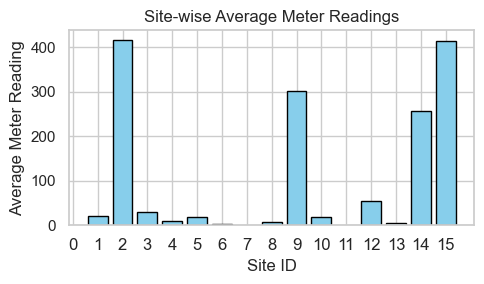

In [99]:
def plot_site_wise_average_meter_readings(train_df):
    """
    Plot bar chart for site-wise average meter readings.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'site_id' and 'meter_reading' columns.
    """
    # Calculate mean meter reading for each site
    site_avg_meter_readings = train_df.groupby('site_id')['meter_reading'].mean()

    # Plot bar chart for site-wise average meter readings
    plt.figure(figsize=(5, 3))
    plt.bar(site_avg_meter_readings.index, site_avg_meter_readings.values, color='skyblue', edgecolor='black')
    plt.title('Site-wise Average Meter Readings', fontsize=12)
    plt.xlabel('Site ID', fontsize=12)
    plt.ylabel('Average Meter Reading', fontsize=12)
    plt.xticks(range(16), fontsize=12)
    plt.tight_layout()
    plt.show()

plot_site_wise_average_meter_readings(train_df)

- site 2,15 have the most high energy consumption
- This is due to the presence of building 1381 in site 15 which is an outlier.

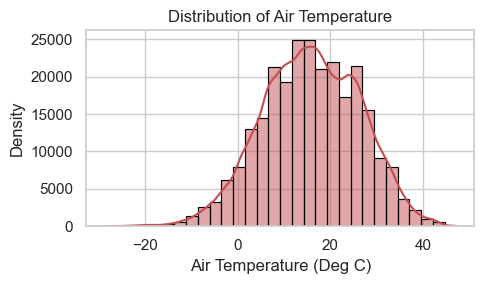

In [111]:
def plot_air_temperature_distribution(train_df):
    """
    Plot the distribution of air temperature using a histogram.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'air_temperature' column.
    """
    # Plot histogram for air temperature distribution
    plt.figure(figsize=(5, 3))
    sns.histplot(train_df['air_temperature'], bins=30, kde=True, color='r', edgecolor='black')
    #plt.hist(train_df['air_temperature'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Air Temperature', fontsize=12)
    plt.xlabel('Air Temperature (Deg C)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_air_temperature_distribution(train_df)

- Air temperature variable follows a normal distribution with most of the values between 0–30 degrees Celsius.

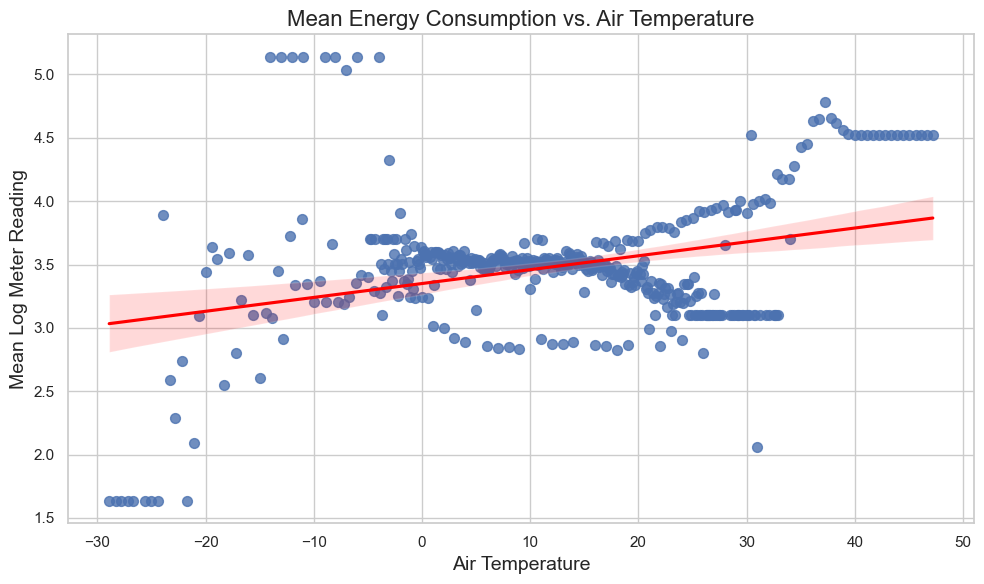

In [112]:
def plot_mean_energy_consumption_vs_air_temperature(train_df):
    """
    Plot the mean log-transformed meter readings against air temperature.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'log_meter_reading' and 'air_temperature' columns.
    """
    # Calculate mean log meter readings for each unique air temperature value
    mean_meter_readings = train_df.groupby('air_temperature')['log_meter_reading'].mean().reset_index()

    # Set style
    sns.set(style="whitegrid")
    
    # Plot scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x='air_temperature', y='log_meter_reading', data=mean_meter_readings, scatter_kws={'s': 50}, line_kws={'color':'red'})
    
    plt.title('Mean Energy Consumption vs. Air Temperature', fontsize=16)
    plt.xlabel('Air Temperature', fontsize=14)
    plt.ylabel('Mean Log Meter Reading', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_mean_energy_consumption_vs_air_temperature(train_df)

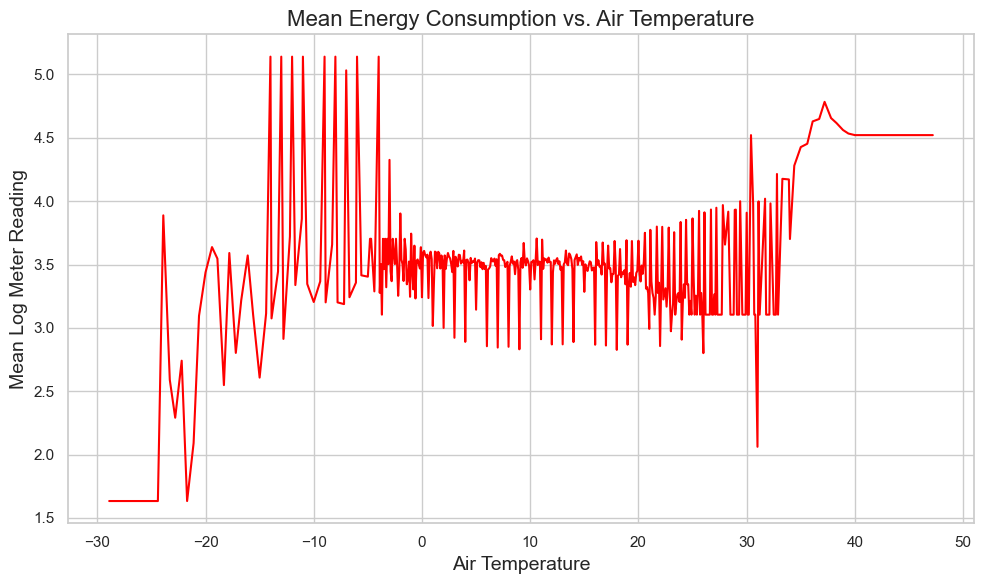

In [113]:
# different view
def plot_mean_energy_consumption_vs_air_temperature(train_df):
    """
    Plot the mean log-transformed meter readings against air temperature using a line graph.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'log_meter_reading' and 'air_temperature' columns.
    """
    # Calculate mean log meter readings for each unique air temperature value
    mean_meter_readings = train_df.groupby('air_temperature')['log_meter_reading'].mean().reset_index()

    # Set style
    sns.set(style="whitegrid")
    
    # Plot line graph
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='air_temperature', y='log_meter_reading', data=mean_meter_readings, color='red')
    
    plt.title('Mean Energy Consumption vs. Air Temperature', fontsize=16)
    plt.xlabel('Air Temperature', fontsize=14)
    plt.ylabel('Mean Log Meter Reading', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_mean_energy_consumption_vs_air_temperature(train_df)

- The average meter readings are high when the temperature is negative, once it starts increasing, the meter consumption reduces. It again increases when the temperature rises above 15 deg C. This behavior is understood by the fact that when temperatures are extremely low heaters are utilized and when temperatures are high air conditioners are used. Both of these leads to higher energy consumption.

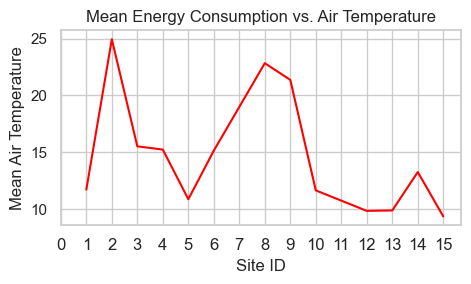

In [118]:
# different view
def plot_mean_energy_consumption_vs_air_temperature(train_df):
    """
    Plot the mean log-transformed meter readings against air temperature using a line graph.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'log_meter_reading' and 'air_temperature' columns.
    """
    # Calculate mean log meter readings for each unique air temperature value
    mean_air_temperature_by_site = train_df.groupby('site_id')['air_temperature'].mean().reset_index()

    # Set style
    sns.set(style="whitegrid")
    
    # Plot line graph
    plt.figure(figsize=(5, 3))
    sns.lineplot(x='site_id', y='air_temperature', data=mean_air_temperature_by_site, color='red')
    
    plt.title('Mean Energy Consumption vs. Air Temperature', fontsize=12)
    plt.xlabel('Site ID', fontsize=12)
    plt.xticks(range(16), fontsize=12)
    plt.ylabel('Mean Air Temperature', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_mean_energy_consumption_vs_air_temperature(train_df)

- The above plot shows the site-wise average temperatures. We can see that different sites have different average temperatures. This proves that the sites do not belong to one location. They are spread across various geographic locations. This can be useful information which we will use in feature engineering.

### Distribution plots for rest of the variables from the weather data:

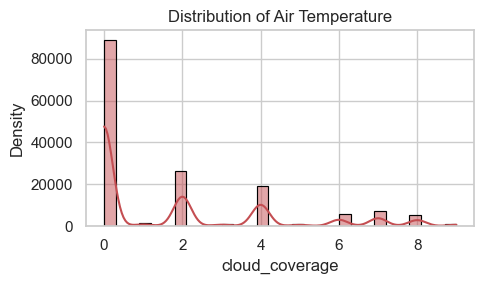

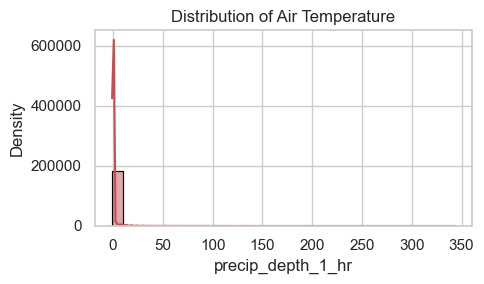

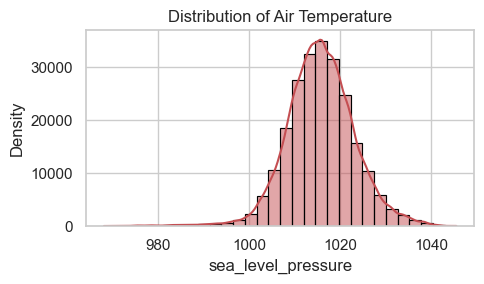

In [142]:
def plot_air_temperature_distribution(train_df,x):
    """
    Plot the distribution of air temperature using a histogram.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'air_temperature' column.
    """
    # Plot histogram for air temperature distribution
    plt.figure(figsize=(5, 3))
    sns.histplot(train_df[x], bins=30, kde=True, color='r', edgecolor='black')
    #plt.hist(train_df['air_temperature'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Air Temperature', fontsize=12)
    plt.xlabel(f'{x}', fontsize=12)
    #plt.xticks(range(16), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_air_temperature_distribution(train_df,'cloud_coverage')
plot_air_temperature_distribution(train_df,'precip_depth_1_hr')
plot_air_temperature_distribution(train_df,'sea_level_pressure')


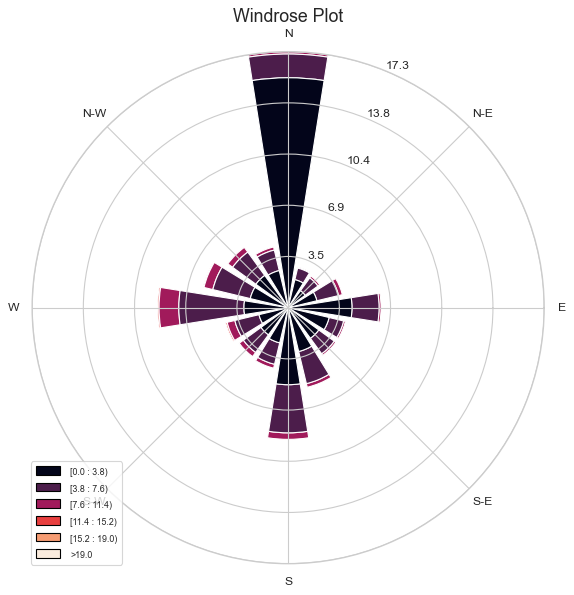

In [131]:
def plot_windrose(train_df):
    """
    Plot windrose using 'wind_direction' and 'wind_speed' data from train_df.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'wind_direction' and 'wind_speed' columns.
    """
    # Create a WindroseAxes object
    ax = WindroseAxes.from_ax()

    # Plot windrose using 'wind_direction' and 'wind_speed' data
    ax.bar(train_df['wind_direction'], train_df['wind_speed'], normed=True, opening=0.8, edgecolor='white')

    # Customize the windrose plot
    ax.set_legend()
    ax.set_title('Windrose Plot', fontsize=16)
    plt.show()

plot_windrose(train_df)

- The dew temperature distribution is bit skewed to the right with maximum values falling between 0–20 deg C.

- Majority of the observations have cloud coverage as zero.

- Precip_depth_1_hr variable is highly skewed with most of the values being zero.

- Sea_level_pressure follows a normal distribution with most of the values falling in between 1000–1030 millibar

- The windrose diagram shows that most for most of the sites, the wind blows from north direction(90 degrees) most of the time, followed by south direction(270 degrees). It also shows that wind blows the least from NE direction(45 degrees). When the wind blows from north, most of the times the speed is 0–3.8 m/s.

## Distributions of floor_count, square_feet and year_built



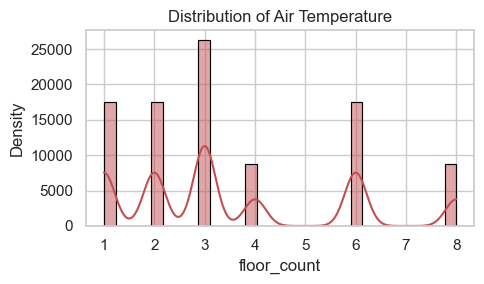

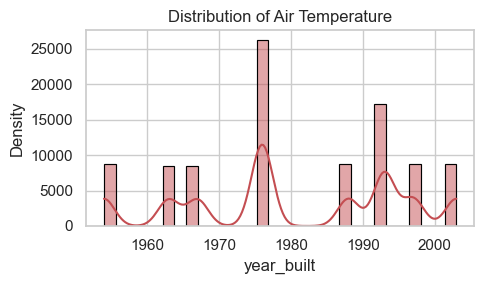

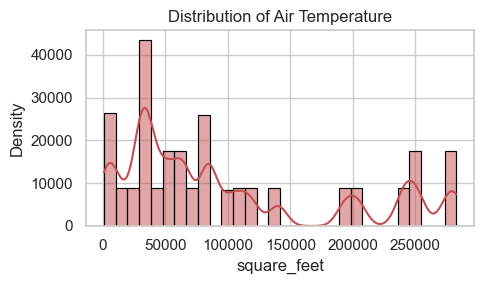

In [143]:
plot_air_temperature_distribution(train_df,'floor_count')
plot_air_temperature_distribution(train_df,'year_built')
plot_air_temperature_distribution(train_df,'square_feet')

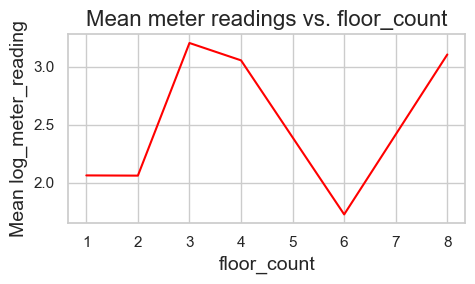

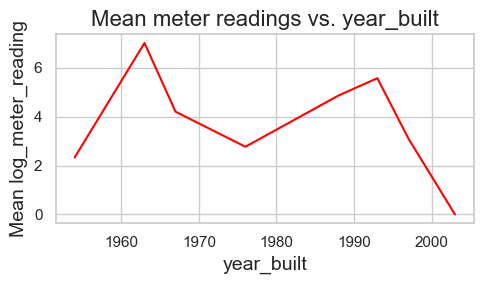

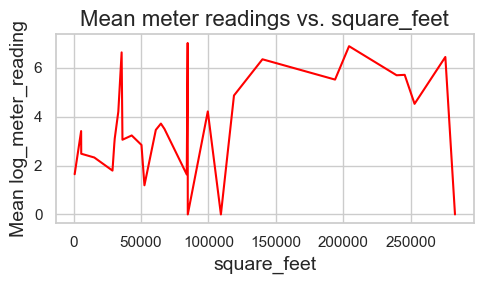

In [147]:
# different view
def plot_mean_energy_consumption_vs_air_temperature(train_df,x):
    """
    Plot the mean log-transformed meter readings against air temperature using a line graph.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with 'log_meter_reading' and 'air_temperature' columns.
    """
    # Calculate mean log meter readings for each unique air temperature value
    mean_meter_readings = train_df.groupby(x)['log_meter_reading'].mean().reset_index()

    # Set style
    sns.set(style="whitegrid")
    
    # Plot line graph
    plt.figure(figsize=(5, 3))
    sns.lineplot(x=x, y='log_meter_reading', data=mean_meter_readings, color='red')
    
    plt.title(f'Mean meter readings vs. {x}', fontsize=16)
    plt.xlabel(f'{x}', fontsize=14)
    plt.ylabel('Mean log_meter_reading', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_mean_energy_consumption_vs_air_temperature(train_df,'floor_count')
plot_mean_energy_consumption_vs_air_temperature(train_df,'year_built')
plot_mean_energy_consumption_vs_air_temperature(train_df,'square_feet')

floor_count:
- We have a lot of missing values in floor_count.

- Most of the buildings have 1 or 2 floors.

- When the floor count is more than 10, the meter reading peaks and then drops. This can be due to several reasons like not all the floors are being used at a given point of time.

year_built:
- This column also has a lot of values missing.

- The distribution is spread over 120 years but most of the buildings are built after 1960.

- The average consumption is higher for buildings built before 1940.

square_feet:

- The square feet variable is heavily skewed and the scale of values is huge hence we take the log transformation of this variable.

- There is a clear positive correlation between the square feet and meter readings.

- As the size of the buildings increases, energy consumption also increases.

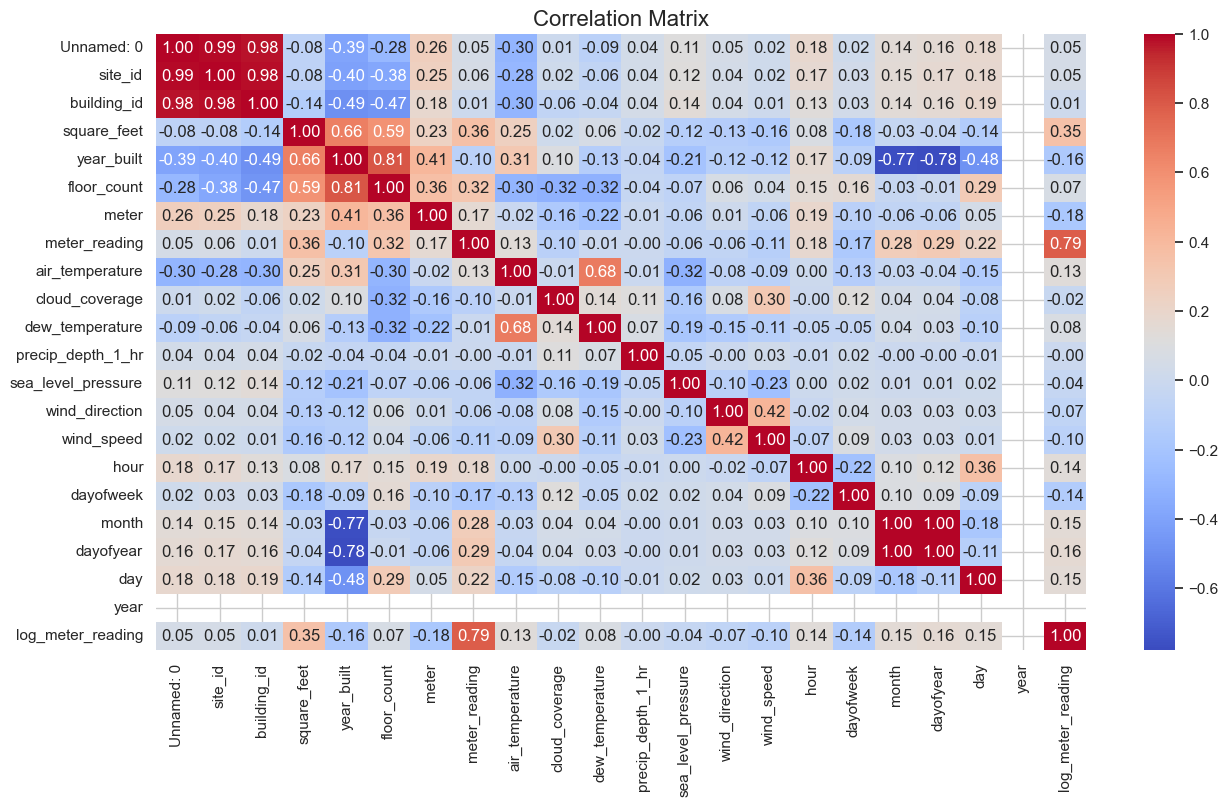

In [149]:
numeric_columns = train_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.show()

- The square feet and floor count features have positive correlation with the target variable.

- As we know the size of the building is a huge factor on how much energy a building consumes. Year built is also having a positive correlation with the target variable as older buildings tend to consume more energy than the newer ones.